In [1]:
# Autor Zhibin Zhao （ZZB)
# For co-simulation, FID CPMG or arbitrary Pulse sequence testing
# Please use it when Debug Hardware ADC and DAC pass

# import library
from pynq import Overlay
from pynq import allocate
import numpy as np
import matplotlib.pyplot as mp

In [2]:
# loading bitstream file
ol = Overlay('./HVNMR.bit')

In [3]:
# loading IP
pulse_gen = ol.fpga_pulse_generator_0
osci = ol.fpga_tracing_0
chip_conf = ol.fpga_nmr_chip_config_0       # chip config control unit define

#config ADCs
adc0 = ol.fpga_ADC_AD7960_0
adc1 = ol.fpga_ADC_AD7960_1
mode = 9
adc0.write(0x0,mode)  
adc1.write(0x0,mode) 

# only use for the HF-cmos NMR Chip / not for the HVNMR 
# ol = Overlay('./MCXO_2.bit')             # ultral low phase noise version (10 ppb clock) pynq Z2
# chip_con.write(0 * 4, 883)               # config data to chip config unit (11bits)0b01110100011
# chip_con.write(1 * 4, 1)                 # chip config start

In [4]:
# pulse generator don't change it 

# start the pulse sequence
C_SEQUENCE_GENERATOR_EN = 0x0

# set the number of section
C_SET_NR_SECTIONS = 0x4

# write section select
C_SEL_SECTION = 0x8

# set section type
C_SET_SECTION_TYPE = 0xC

# set section duration
C_SET_DELAY = 0x10

# set section muxplexer
C_SET_MUX = 0x14

# set repetition start section pointer
C_SET_START_REPEAT_POINTER = 0x18

# set repetition end section pointer
C_SET_END_REPEAT_POINTER = 0x1C

# set cycle repetition number
C_SET_CYCLE_REPETITION_NUMBER = 0x20

# set experiment repetition number
C_SET_EXPERIMENT_REPETITION_NUMBER = 0x24

# channel 0 set phase
C_SET_PHASE_CH0 = 0x28

# channel 0 set frequency
C_SET_FREQUENCY_CH0 = 0x2C

# channel 1 set phase
C_SET_PHASE_CH1 = 0x30

# channel 1 set frequency
C_SET_FREQUENCY_CH1 = 0x34

# DDS reset
C_SET_RESETN_DDS = 0x38

# channel busy signal
C_GET_BUSY = 0x3C

# channel data ready signal
C_GET_DATA_READY = 0x40

# set number of DDS channel
C_GET_NR_DDS_CH = 0x44

# set memory depth
C_GET_MEM_DEPTH = 0x48

# set number of activity
C_GET_NR_ACTIVITY = 0x4C

# start
# C_START = 80   # 0x50

# write configuration data or experiment execution command
SetCommand = lambda command,value: pulse_gen.write(command,value)

# read data from pulse generator IP core
GetData = lambda command: pulse_gen.read(command)

def Sec_Config(sec,s_type,delay,mux,p0,f0,p1,f1,rstn):
        # choose section to configure
        SetCommand(C_SEL_SECTION,sec)
        # define section type
        SetCommand(C_SET_SECTION_TYPE,s_type)
        # define delay duration
        SetCommand(C_SET_DELAY,delay)        
        # define multiplexer type
        SetCommand(C_SET_MUX,mux)
        # DDS channel 0 phase
        SetCommand(C_SET_PHASE_CH0,p0)
        # DDS channel 0 frequency
        SetCommand(C_SET_FREQUENCY_CH0,f0)
        # DDS channel 1 phase
        SetCommand(C_SET_PHASE_CH1,p1)
        # DDS channel 1 frequency
        SetCommand(C_SET_FREQUENCY_CH1,f1)
        # Reset
        SetCommand(C_SET_RESETN_DDS,rstn)
        
def Exp_Config():
    SetCommand(C_SET_NR_SECTIONS, section_nr)

    SetCommand(C_SET_START_REPEAT_POINTER, start_pointer)

    SetCommand(C_SET_END_REPEAT_POINTER, end_pointer)
    
    SetCommand(C_SET_CYCLE_REPETITION_NUMBER, cycle_repetition_number)
    
    SetCommand(C_SET_EXPERIMENT_REPETITION_NUMBER, experiment_repetition_number)

In [5]:
# tracing module
# enable
C_ENABLE_CMD = 0*4

def enable():
    osci.write(C_ENABLE_CMD,1)
    
def disable():
    osci.write(C_ENABLE_CMD,0)
    
# run the single shot
C_SINGLE_SHOT_CMD = 1*4
def single_shot():
    osci.write(C_SINGLE_SHOT_CMD,1)
    
# select the analog trigger chanel 
C_SELECT_ANALOG_TRIGGER_CHANNEL_CMD = 2*4
def trigger_channel(data):
    osci.write(C_SELECT_ANALOG_TRIGGER_CHANNEL_CMD,data)
    
# set the analog trigger edge rising edge or falling edge enable
C_SET_ANALOG_TRIGGER_RISING_EDGE_CMD = 3*4
def trigger_ris_edge():
    osci.write(C_SET_ANALOG_TRIGGER_RISING_EDGE_CMD,1)
    
# set the analog trigger edge falling edge or falling edge enable
C_SET_ANALOG_TRIGGER_FALLING_EDGE_CMD = 4*4
def trigger_fal_edge():
    osci.write(C_SET_ANALOG_TRIGGER_FALLING_EDGE_CMD,1)
    
# set the digital chanle trigger rising edge enable 
C_BIN_CH_RE_TRIG_EN_CMD = 5*4
def digtal_trigger_ris_edge():
    osci.write(C_BIN_CH_RE_TRIG_EN_CMD,1)
    
# set the digital chanel trigger falling edge enable
C_BIN_CH_FE_TRIG_EN_CMD = 6*4
def digtal_trigger_fal_edge():
    osci.write(C_BIN_CH_FE_TRIG_EN_CMD,1)
    
# arm (register interface)
C_ARM_CMD = 7*4
def arm():
    osci.write(C_ARM_CMD,1)
    
# set the number of sumples, max 2^ memory depth
C_SET_NR_SAMPLES_CMD = 8*4
def set_nr_smaples(data):
    osci.write(C_SET_NR_SAMPLES_CMD,data)
    
# set clock size Program Logic clock over the step of size
C_CLOCK_STEP_SIZE_CMD = 9*4
def clock_step_size(data):
    osci.write(C_CLOCK_STEP_SIZE_CMD,data)
    
# trigger delay function using for the trigger center for ploting
C_SET_TRIGGER_DELAY_CMD = 10*4
def trigger_delay(data):
    osci.write(C_SET_TRIGGER_DELAY_CMD,data)
    
# select the read memory from channel 
C_SELECT_READ_MEMORY_CMD = 11*4
def select_read_memory(data):
    osci.write(C_SELECT_READ_MEMORY_CMD,data)
    
# set the current read address for block ram
C_SET_CURRENT_READ_ADDRESS_CMD = 12*4
def reset_current_read_addr():
    osci.write(C_SET_CURRENT_READ_ADDRESS_CMD,0)
def set_read_addr(data):
    osci.write(C_SET_CURRENT_READ_ADDRESS_CMD,data)
    
# read data
C_READ_DATA = 13*4
def rd_date():
    data = osci.read(C_READ_DATA)
    return data
# get the number of the analog channels
C_GET_NR_ANALOG_CHANNELS_CMD = 14*4
def get_nr_AnalogChannel():
    data = osci.read(C_GET_NR_ANALOG_CHANNELS_CMD)
    print (f"Number of analog channels by VHDL setting:{data}")

# get the number of digital channels
C_GET_NR_DIGITAL_CHANNELS_CMD = 15*4
def get_nr_DigitalChannel():
    data = osci.read(C_GET_NR_DIGITAL_CHANNELS_CMD)
    print (f"Number of digital channels by VHDL setting:{data}")

# get the number of analog memories
C_GET_NR_ANALOG_MEMORIES_CMD = 16*4
def get_nr_AnalogMemories():
    data = osci.read(C_GET_NR_ANALOG_MEMORIES_CMD)
    print (f"Number of analog memory:{data}")    

# get the number of digital meories
C_GET_NR_DIGITAL_MEMORIES_CMD = 17*4
def get_nr_DigitalMemories():
    data = osci.read(C_GET_NR_DIGITAL_MEMORIES_CMD)
    print (f"Number of digital memory:{data}")        

# get the memory depth of analog channel
C_GET_MEMORY_DEPTH_CMD = 18*4
def get_nr_MemDepth():
    data = osci.read(C_GET_MEMORY_DEPTH_CMD)
    print (f"Memory depth:{data}")        

# read the busy of block
C_READ_BUSY_SIGNAL_CMD = 19*4
def busy():
    data = osci.read(C_READ_BUSY_SIGNAL_CMD)
    print (f"busy:{data}") 

# read the rady signal 
C_READ_READY_SIGNAL_CMD = 20*4
def ready():
    data = osci.read(C_READ_READY_SIGNAL_CMD)
    print (f"ready:{data}")     

# toggle the led
C_TOGGLE_LED_CMD = 21*4
def led():
    osci.write(C_TOGGLE_LED_CMD,1)
    
# set the analog trigger threshold voltage
C_SET_ANALOG_TRIGGER_THRESHOLD_CMD = 22*4
def trigger_threshold(data):
    osci.write(C_SET_ANALOG_TRIGGER_THRESHOLD_CMD,data)
    
# control mux select analog memory
C_CTRL_MUX_SELECT_ANALOG_MEMORY_CMD = 23*4
def mux_Memory(data):
    osci.write(C_CTRL_MUX_SELECT_ANALOG_MEMORY_CMD,data)
    
# control mux select analog channel  
C_CTRL_MUX_SELECT_ANALOG_CH_CMD = 24*4
def mux_Channel(data):
    osci.write(C_CTRL_MUX_SELECT_ANALOG_CH_CMD,data)

# set the number of rx pulse
C_SET_STREAM_NR_RX_PULSE = 25*4
def set_stream_number_rx_pulse(data):
    osci.write(C_SET_STREAM_NR_RX_PULSE,data)
    
# start stream transfer
C_START_STREAM = 26*4
def start_stream_transfer():
    osci.write(C_START_STREAM,1)
    
# type of stream arm 0 single shot 1
C_TYPE_STREAM = 27*4
def type_stream(data):
    osci.write(C_TYPE_STREAM,data)
    
# read total rest samples    
C_REST_SAMPLES = 28*4
def rest_samples():
    data = osci.read(C_REST_SAMPLES)
    print (f"rest samples:{data}")

# read stream busy
C_READ_STREAM_BUSY = 29*4
def stream_busy():
    data = osci.read(C_READ_STREAM_BUSY)
    print (f"stream busy:{data}")
    

In [6]:
# HVNMR CHIP config
# Constants
register_width = 32

# Register 0 and 2 are for SPI data
# Register 1 is for start the transmission
# Register 3 is for read out of done signal

Address_register_SPI_data = tuple(x * 4 for x in (0, 2))
Address_register_start = 1 * 4
Address_register_done = 3 * 4 # 末尾加,为元组

# Sub-adress of SPI configuration under Register 0 and 2, 55 bits in total

sub_addr_array = [
    0,   # Sub_Address_SPI_pll_en
    1,   # Sub_Address_SPI_gain
    2,   # Sub_Address_SPI_skip_mixer
    3,   # Sub_Address_SPI_prescaler_pll
    5,   # Sub_Address_SPI_N_divider_pll
    10,  # Sub_Address_SPI_prescaler_tx_logic
    12,  # Sub_Address_SPI_tx_shortening_counter
    20,  # Sub_Address_SPI_deadtime_hs_p
    24,  # Sub_Address_SPI_deadtime_ls_p
    28,  # Sub_Address_SPI_deadtime_hs_n
    32,  # Sub_Address_SPI_deadtime_ls_n
    36,  # Sub_Address_SPI_deadtime_comp_p
    40,  # Sub_Address_SPI_deadtime_comp_n
    44,  # Sub_Address_SPI_delay_p
    48,  # Sub_Address_SPI_delay_n
    52,  # Sub_Address_SPI_amplifier_reset
    53,  # Sub_Address_SPI_pll_or_spi_output
    54   # Sub_Address_SPI_ls
]

# 18 SPI configuration commands in total

Sub_Address_SPI_pll_en = 0
Sub_Address_SPI_gain = 1
Sub_Address_SPI_skip_mixer = 2
Sub_Address_SPI_prescaler_pll = 3
Sub_Address_SPI_N_divider_pll = 4
Sub_Address_SPI_prescaler_tx_logic = 5
Sub_Address_SPI_tx_shortening_counter = 6
Sub_Address_SPI_deadtime_hs_p = 7
Sub_Address_SPI_deadtime_ls_p = 8
Sub_Address_SPI_deadtime_hs_n = 9
Sub_Address_SPI_deadtime_ls_n = 10
Sub_Address_SPI_deadtime_comp_p = 11
Sub_Address_SPI_deadtime_comp_n = 12
Sub_Address_SPI_delay_p = 13
Sub_Address_SPI_delay_n = 14
Sub_Address_SPI_amplifier_reset = 15
Sub_Address_SPI_pll_or_spi_output = 16
Sub_Address_SPI_ls = 17
# Basic functions

# Read whole register value
def read_register(address):
    return chip_conf.read(address)

# Write whole register value
def write_register(address, val):
    return chip_conf.write(address, val)

# Clear all registers
def clear_register():
    chip_conf.write(Address_register_SPI_data[0], 0)
    chip_conf.write(Address_register_SPI_data[1], 0)
    chip_conf.write(Address_register_start, 0)
    chip_conf.write(Address_register_done, 0)

# Read SPI data register sub-function value
def read_spi_sub_address(sub_address):
    cur = chip_conf.read(Address_register_SPI_data[1]) + 2**32 * chip_conf.read(Address_register_SPI_data[0])
    if (sub_address == 17):
        len = 1
    else:
        len = sub_addr_array[sub_address + 1] - sub_addr_array[sub_address]
    result = (cur >> (9 + sub_addr_array[sub_address])) % (2**len)
    return result
    
# Read SPI data register specific bit value
def read_bit(address, bit):
    pass
    
# Write SPI data register sub-function value
def write_spi_sub_address(sub_address, set_val):
    address = Address_register_SPI_data[0] if sub_addr_array[sub_address] > 22 else Address_register_SPI_data[1]  # firstly find out whether the subaddress in register 0 or 2
    cur_0 = read_register(Address_register_SPI_data[0])
    cur_2 = read_register(Address_register_SPI_data[1])
    if (sub_address == Sub_Address_SPI_deadtime_hs_p): # special, need change both register 0 and 2
        print("Command in both register 0 and register 2.")
        print(4)
        if (set_val >= 8):
            masked = cur_0 & (2 ** register_width - 1 - 1)
            result_0 = masked | 1
            set_val = set_val - 8
            # print(set_val)
        else:
            masked = cur_0 & (2 ** register_width - 1 - 1)
            result_0 = masked
        chip_conf.write(Address_register_SPI_data[0], result_0)
        max_val = 7
        set_val = set_val if (set_val<=max_val) else max_val
        print(set_val)
        masked = cur_2 & (2 ** register_width - 1 - (max_val << 29))
        result_2 = masked | (set_val << 29)
        chip_conf.write(Address_register_SPI_data[1], result_2)
    else:
        if (sub_address == 17):
            len = 1
        else:
            len = sub_addr_array[sub_address + 1] - sub_addr_array[sub_address]
        print(len)
        max_val = 2 ** len - 1
        if (set_val > max_val):
            set_val = max_val
        if (address == Address_register_SPI_data[1]):
            masked = cur_2 & (2 ** register_width - 1 - (max_val << (sub_addr_array[sub_address] + 9)))
            result_2 = masked | (set_val << (sub_addr_array[sub_address] + 9))
            chip_conf.write(Address_register_SPI_data[1], result_2)
        else:
            masked = cur_0 & (2 ** register_width - 1 - (max_val << (sub_addr_array[sub_address] - 23)))
            result_0 = masked | (set_val << (sub_addr_array[sub_address] - 23))
            chip_conf.write(Address_register_SPI_data[0], result_0)
    return

def spi_write_start(val): # rising edge trigger
    chip_conf.write(Address_register_start, val)
    
def spi_read_finish(): # spi finish signal
    chip_conf.read(Address_register_done)
# Bit 0: internal PLL
def spi_read_pll_en():
    return read_spi_sub_address(Sub_Address_SPI_pll_en)
def spi_write_pll_en(val):
    return write_spi_sub_address(Sub_Address_SPI_pll_en, val)

# Bit 1: gain
def spi_read_gain():
    return read_spi_sub_address(Sub_Address_SPI_gain)
def spi_write_gain(val):
    return write_spi_sub_address(Sub_Address_SPI_gain, val)

# Bit 2: skip_mixer
def spi_read_skip_mixer():
    return read_spi_sub_address(Sub_Address_SPI_skip_mixer)
def spi_write_skip_mixer(val):
    return write_spi_sub_address(Sub_Address_SPI_skip_mixer, val)

# Bit 3-4: prescaler_pll
def spi_read_prescaler_pll():
    return read_spi_sub_address(Sub_Address_SPI_prescaler_pll)
def spi_write_prescaler_pll(val):
    return write_spi_sub_address(Sub_Address_SPI_prescaler_pll, val)

# Bit 5-9: N_divider_pll
def spi_read_N_divider_pll():
    return read_spi_sub_address(Sub_Address_SPI_N_divider_pll)
def spi_write_N_divider_pll(val):
    return write_spi_sub_address(Sub_Address_SPI_N_divider_pll, val)

# Bit 10-11: prescaler_tx_logic
def spi_read_prescaler_tx_logic():
    return read_spi_sub_address(Sub_Address_SPI_prescaler_tx_logic)
def spi_write_prescaler_tx_logic(val):
    return write_spi_sub_address(Sub_Address_SPI_prescaler_tx_logic, val)

# Bit 12-19: tx_shortening_counter
def spi_read_tx_shortening_counter():
    return read_spi_sub_address(Sub_Address_SPI_tx_shortening_counter)
def spi_write_tx_shortening_counter(val):
    return write_spi_sub_address(Sub_Address_SPI_tx_shortening_counter, val)

# Bit 20-23: deadtime_hs_p
def spi_read_deadtime_hs_p():
    return read_spi_sub_address(Sub_Address_SPI_deadtime_hs_p)
def spi_write_deadtime_hs_p(val):
    return write_spi_sub_address(Sub_Address_SPI_deadtime_hs_p, val)

# Bit 24-27: deadtime_ls_p
def spi_read_deadtime_ls_p():
    return read_spi_sub_address(Sub_Address_SPI_deadtime_ls_p)
def spi_write_deadtime_ls_p(val):
    return write_spi_sub_address(Sub_Address_SPI_deadtime_ls_p, val)

# Bit 28-31: deadtime_hs_n
def spi_read_deadtime_hs_n():
    return read_spi_sub_address(Sub_Address_SPI_deadtime_hs_n)
def spi_write_deadtime_hs_n(val):
    return write_spi_sub_address(Sub_Address_SPI_deadtime_hs_n, val)

# Bit 32-35: deadtime_ls_n
def spi_read_deadtime_ls_n():
    return read_spi_sub_address(Sub_Address_SPI_deadtime_ls_n)
def spi_write_deadtime_ls_n(val):
    return write_spi_sub_address(Sub_Address_SPI_deadtime_ls_n, val)

# Bit 36-39: deadtime_comp_p
def spi_read_deadtime_comp_p():
    return read_spi_sub_address(Sub_Address_SPI_deadtime_comp_p)
def spi_write_deadtime_comp_p(val):
    return write_spi_sub_address(Sub_Address_SPI_deadtime_comp_p, val)

# Bit 40-43: deadtime_comp_n
def spi_read_deadtime_comp_n():
    return read_spi_sub_address(Sub_Address_SPI_deadtime_comp_n)
def spi_write_deadtime_comp_n(val):
    return write_spi_sub_address(Sub_Address_SPI_deadtime_comp_n, val)

# Bit 44-47: delay_p
def spi_read_delay_p():
    return read_spi_sub_address(Sub_Address_SPI_delay_p)
def spi_write_delay_p(val):
    return write_spi_sub_address(Sub_Address_SPI_delay_p, val)

# Bit 48-51: delay_n
def spi_read_delay_n():
    return read_spi_sub_address(Sub_Address_SPI_delay_n)
def spi_write_delay_n(val):
    return write_spi_sub_address(Sub_Address_SPI_delay_n, val)

# Bit 52: amplifier_reset
def spi_read_amplifier_reset():
    return read_spi_sub_address(Sub_Address_SPI_amplifier_reset)
def spi_write_amplifier_reset(val):
    return write_spi_sub_address(Sub_Address_SPI_amplifier_reset, val)

# Bit 53: pll_or_spi_output
def spi_read_pll_or_spi_output():
    return read_spi_sub_address(Sub_Address_SPI_pll_or_spi_output)
def spi_write_pll_or_spi_output(val):
    return write_spi_sub_address(Sub_Address_SPI_pll_or_spi_output, val)

# Bit 54: ls
def spi_read_ls():
    return read_spi_sub_address(Sub_Address_SPI_ls)
def spi_write_ls(val):
    return write_spi_sub_address(Sub_Address_SPI_ls, val)



In [7]:
import time

clear_register()
spi_write_pll_en(1)
spi_write_gain(1)
spi_write_skip_mixer(1)
spi_write_prescaler_pll(3)
spi_write_N_divider_pll(2**5-1)
spi_write_prescaler_tx_logic(3)
spi_write_tx_shortening_counter(2**8-1)
spi_write_deadtime_hs_p(15)
spi_write_deadtime_ls_p(15)
spi_write_deadtime_hs_n(15)
spi_write_deadtime_ls_n(15)
spi_write_deadtime_comp_p(15)
spi_write_deadtime_comp_n(15)
spi_write_delay_p(15)
spi_write_delay_n(15)
spi_write_pll_or_spi_output(1)
spi_write_amplifier_reset(1)
spi_write_ls(1)
spi_write_start(1)

time.sleep(1)

clear_register()
spi_write_pll_en(1)
spi_write_gain(1)
spi_write_skip_mixer(1)
spi_write_prescaler_pll(3)
spi_write_N_divider_pll(2**5-1)
spi_write_prescaler_tx_logic(3)
spi_write_tx_shortening_counter(2**8-1)
spi_write_deadtime_hs_p(15)
spi_write_deadtime_ls_p(15)
spi_write_deadtime_hs_n(15)
spi_write_deadtime_ls_n(15)
spi_write_deadtime_comp_p(15)
spi_write_deadtime_comp_n(15)
spi_write_delay_p(15)
spi_write_delay_n(15)
spi_write_pll_or_spi_output(1)
spi_write_amplifier_reset(0)
spi_write_ls(1)
spi_write_start(1)

1
1
1
2
5
2
8
Command in both register 0 and register 2.
4
7
4
4
4
4
4
4
4
1
1
1
1
1
1
2
5
2
8
Command in both register 0 and register 2.
4
7
4
4
4
4
4
4
4
1
1
1


## FID (don't run the following cells, if you choose CPMG)

In [8]:
# Set TX and RX frequency (Tx Larmor frequency)
f_tx = 1 # in MHz
f_rx = 2 # in MHz

In [9]:
# parameters of pulses setup
section_nr = 7       # 0 - 12
start_pointer = 1
end_pointer = 5
cycle_repetition_number = 1
experiment_repetition_number = 1
Exp_Config()

# generate pulses (tx,rx,fref)
t = 100                          # 1us -- 250MHz
TE = 3000*t                      # Echo Time
pi = 2147483648                  # 180 degree, for 32 bits phase width
f0 = 17179869                     # 1MHz, for 32 bits phase width
# f = f * 7.61                   # 7.651Mhz for small magnet
# f = f * 7.75                   # 7.75Mhz for big magnet
f = f0 * f_tx                  # 6Mhz for Bosch magnet
fl = f0 * f_rx

l_type  =  [2,0,2,2,1,2,2] # 0 = TX, 1 = RX, 2 = delay
l_delay =  [1*t,50*t,10*t,10*t,50*t,500*t,500*t] # duration
l_mux   =  [0,0,0,0,1,0,0] # multiplexer

l_p0    =  [0,0,0,0,0,0,0] # phase for DDS0 TX
l_f0    =  [f,f,f,f,f,f,f] # frequency for DDS 
l_p1    =  [0,0,0,0,0,0,0] # phase for DDS1 RX
l_f1    =  [fl,fl,fl,fl,fl,fl,fl]
l_rstn  =  [0,1,1,1,1,1,1] # reset  DDS low enable

for i in range(0,len(l_delay)):
    l_delay[i] = int(l_delay[i])
    l_p0[i] = int(l_p0[i])
    l_f0[i] = int(l_f0[i])
    l_p1[i] = int(l_p1[i])
    l_f1[i] = int(l_f1[i])
    l_rstn[i] = int(l_rstn[i])
    
t_total = sum(l_delay[0:start_pointer-1]) + cycle_repetition_number * sum(l_delay[start_pointer - 1: end_pointer]) + sum(l_delay[end_pointer:section_nr])
t_total = experiment_repetition_number * t_total / (t * 1000)
print("Total NMR Sequence Duration is: %s ms." %t_total)

SetCommand(C_SEQUENCE_GENERATOR_EN,0)
for i in range(0,section_nr):
    Sec_Config(i,l_type[i],l_delay[i],l_mux[i],l_p0[i],l_f0[i],l_p1[i],l_f1[i],l_rstn[i])

Total NMR Sequence Duration is: 1.121 ms.


In [10]:
SetCommand(C_SEQUENCE_GENERATOR_EN,0)    
SetCommand(C_SEQUENCE_GENERATOR_EN,1)

## CPMG (don't run the following 2 cells if you choose FID)

In [11]:
# Set TX and RX frequency here  (Tx Larmor frequency)
f_tx = 5.9906 # in MHz
f_rx = 6.0031 # in MHz

In [12]:
#CPMG
# parameters of pulses setup
section_nr = 12       # 0 - 11
start_pointer = 5
end_pointer = 10
cycle_repetition_number = 5
experiment_repetition_number = 1
Exp_Config()

# generate pulses (tx,rx,fref)
t = 100                          # 1us -- 100MHz system clock frequency
TE = 1200*t                      # Echo Time
pi = 2147483648                  # 180 degree, for 32 bits phase width
f0 = 17179869                    # 1MHz, for 32 bits phase width
# f = f * 7.61                   # 7.651Mhz for small magnet
# f = f * 7.75                   # 7.75Mhz for big magnet
f = f0 *  f_tx                 # 6Mhz for Bosch magnet
fl = f0 * f_rx
P_90 = t*225 #95u
P_180 = t*450
pulse_delay = TE/2 - (P_90 + P_180)/2 - 5*t
P_RX = t*300
pulse_delay_1 = TE/2 - P_RX/2 - P_180/2 - 5*t
l_type  =  [2,2,0,2,2,0,2,2,1,2,2,2] # 0 = TX, 1 = RX, 2 = delay
l_delay =  [5*t,5*t,P_90,5*t,pulse_delay,P_180,pulse_delay_1,5*t,P_RX,5*t,pulse_delay_1,1000*t] # duration
l_mux   =  [0,0,0,0,0,0,0,1,1,1,0,0] # multiplexer
l_p1    =  [0,0,0,0,pi,pi,pi,0,0,0,pi,0]
l_f1    =  [f,f,f,f,f,f,f,f,f,f,f,f]
l_p0    =  [0,0,0,0,0,0,0,0,0,0,0,0]
l_f0    =  [f,f,f,fl,fl,fl,fl,fl,fl,fl,fl,fl]
l_rstn  =  [1,1,1,1,1,1,1,1,1,1,1,1]

for i in range(0,section_nr):
    l_delay[i] = int(l_delay[i])
    l_p0[i] = int(l_p0[i])
    l_f0[i] = int(l_f0[i])
    l_p1[i] = int(l_p1[i])
    l_f1[i] = int(l_f1[i])
    l_rstn[i] = int(l_rstn[i])
    
t_total = sum(l_delay[0:start_pointer-1]) + cycle_repetition_number * sum(l_delay[start_pointer - 1: end_pointer]) + sum(l_delay[end_pointer:section_nr])
t_total = experiment_repetition_number * t_total / (t * 1000)
print("Total NMR Sequence Duration is: %s ms." %t_total)

SetCommand(C_SEQUENCE_GENERATOR_EN,0)
for i in range(0,section_nr):
    Sec_Config(i,l_type[i],l_delay[i],l_mux[i],l_p0[i],l_f0[i],l_p1[i],l_f1[i],l_rstn[i])

Total NMR Sequence Duration is: 7.6475 ms.


In [13]:
#Set receiving channel

single_nr_pkg = 65536
nr_of_samples = cycle_repetition_number * experiment_repetition_number * single_nr_pkg
nr_of_rx = cycle_repetition_number * experiment_repetition_number
nr_of_total_bytes = nr_of_samples * 16

# DMA initialize
dma = ol.axi_dma_0
dma_send = ol.axi_dma_0.sendchannel
dma_recv = ol.axi_dma_0.recvchannel

# initialize RAM
output_buffer_0 = allocate(shape=(((2**18)*16),), dtype=np.int32)
output_buffer_1 = allocate(shape=(((2**18)*16),), dtype=np.int32)

In [14]:
import time
def avg():
    disable()
    enable()
    clock_step_size(50)
    osci.write(C_BIN_CH_RE_TRIG_EN_CMD,1)
    osci.write(C_BIN_CH_FE_TRIG_EN_CMD,0)
    set_nr_smaples(single_nr_pkg)
    set_stream_number_rx_pulse(nr_of_rx)       # set Nr of Package of each experiment    
    type_stream(0)                             # 0 = arm , 1= single shot
    dma_recv.transfer(output_buffer_0[0:nr_of_total_bytes:1])   
    start_stream_transfer()
    SetCommand(C_SEQUENCE_GENERATOR_EN,0)    
    SetCommand(C_SEQUENCE_GENERATOR_EN,1)
    

Start experiment

In [15]:
exp_num = 1

for i in range(exp_num):
    avg()
    output_buffer_1 += output_buffer_0
output_buffer_1 = output_buffer_1 / exp_num


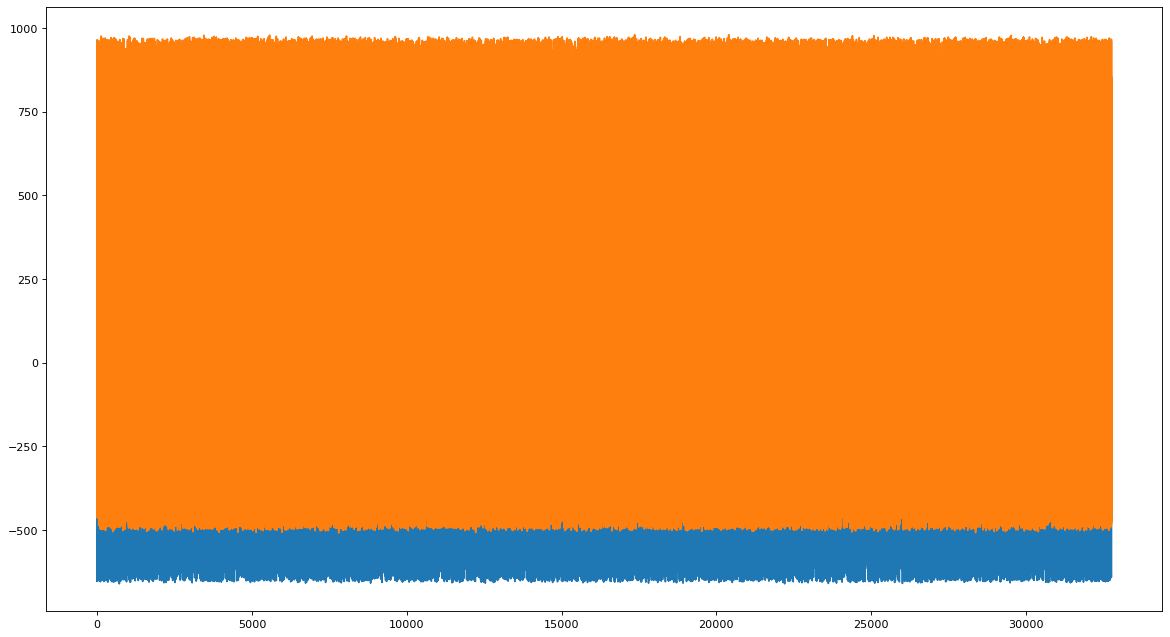

In [16]:
# plot
Analog0_stream = []
Analog1_stream = []
for i in range(1,2**15):
    channel0 = output_buffer_0[0+i*2] #0 = 26,28(purple board); 1 = 30,32; 2 = 38,40; 3 = 34,36
    channel1 = output_buffer_0[1+i*2] #0 = 26,28(purple board); 1 = 30,32; 2 = 38,40; 3 = 34,36
    Analog0_stream.append(channel0)
    Analog1_stream.append(channel1)    
mp.figure(figsize=(18, 10), dpi=80)
mp.plot(Analog0_stream[:50000])
mp.plot(Analog1_stream[:50000])

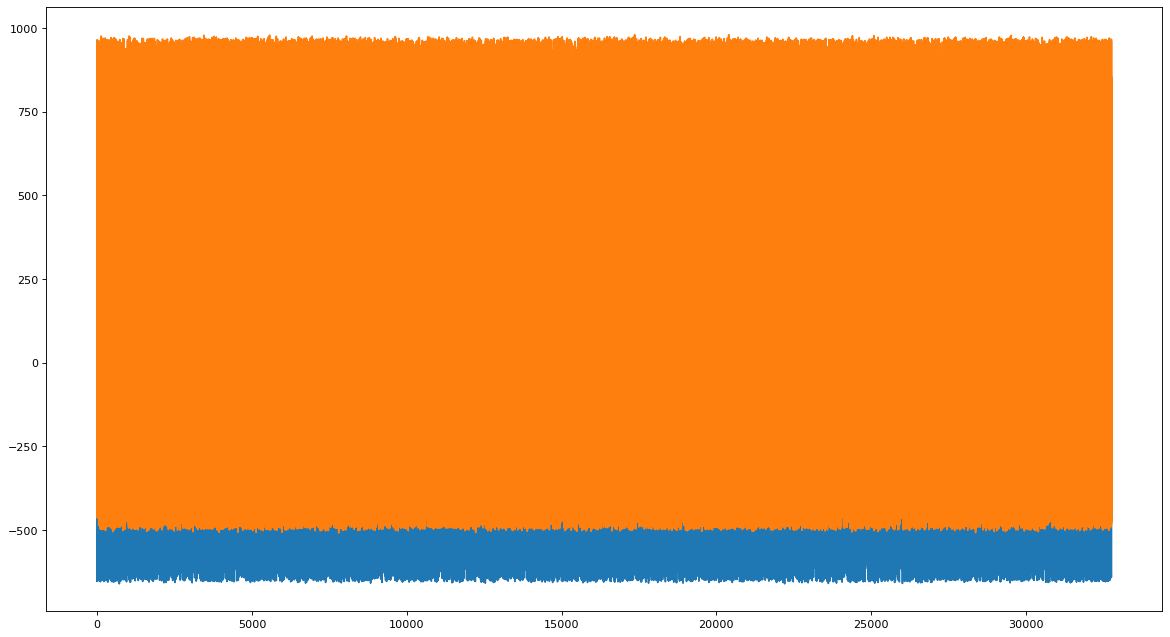

In [17]:
# plot
Analog0_stream = []
Analog1_stream = []
for i in range(1,2**15):
    channel0 = output_buffer_0[0+i*2] #0 = 26,28(purple board); 1 = 30,32; 2 = 38,40; 3 = 34,36
    channel1 = output_buffer_0[1+i*2] #0 = 26,28(purple board); 1 = 30,32; 2 = 38,40; 3 = 34,36
    Analog0_stream.append(channel0)
    Analog1_stream.append(channel1)    
mp.figure(figsize=(18, 10), dpi=80)
mp.plot(Analog0_stream[:50000])
mp.plot(Analog1_stream[:50000])